# Client-Dataset: Yelp Dataset

## Questions
1. Where are coffee companies and other related businesses located based on their characteristics?
2. What are the operating hours of businesses related to our client?
3. Which factors are important to customers based on reviews?

## Hypothesis
1. The more reviews a business has, the more stars it will have

## Approach
1. Design a map and explore business properties based on their location
2. Explore the distribution of businesses' operating hours 
3. Explore correlation between number of reviews and overall business star rating
4. Explore business attributes that are frequently discussed in reviews
4. Apply topic modelling algorithm to extract useful topics from reviews

In [1]:
# Import necessary python libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from pandasql import sqldf

# Define a reusable function for running SQL queries
run_query = lambda query: sqldf(query, globals())

load_dotenv()

True

### Define functions to import and export data

In [3]:
# Function to get compressed json file from AWS s3 bucket
def get_s3_json(file_key):
    
    # Fetch credentials to access AWS s3 bucket
    AWS_S3_BUCKET = os.environ.get('AWS_S3_BUCKET')
    AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
    AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')

    # Construct the full S3 path
    s3_path = f's3://{AWS_S3_BUCKET}/{file_key}'

    # Read the csv file from S3 directly into a pandas DataFrame
    df = pd.read_json(s3_path,  storage_options= {
        "key": AWS_ACCESS_KEY_ID,
        "secret": AWS_SECRET_ACCESS_KEY
         }, lines=True, compression='gzip')

    return df

# Function to get json compressed file from S3 in chunks
def get_s3_json_in_chunks(file_key, size):

    # Fetch credentials to access AWS s3 bucket
    AWS_S3_BUCKET = os.environ.get('AWS_S3_BUCKET')
    AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
    AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')

     # Construct the full S3 path
    s3_path = f's3://{AWS_S3_BUCKET}/{file_key}'

     # Read the csv file from S3 directly into a pandas DataFrame
    df = pd.read_json(s3_path,  storage_options= {
        "key": AWS_ACCESS_KEY_ID,
        "secret": AWS_SECRET_ACCESS_KEY
         }, lines=True, compression='gzip', chunksize=size)

    return df

# Function to convert pandas dataframe to csv and write the file to S3
def export_csv_to_S3(df, file_key):

    # Fetch credentials to access AWS s3 bucket
    AWS_S3_BUCKET = os.environ.get('AWS_S3_BUCKET')
    AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
    AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')

     # Construct the full S3 path
    s3_path = f's3://{AWS_S3_BUCKET}/{file_key}'

    df.to_csv(s3_path, index=False, storage_options={
        "key": AWS_ACCESS_KEY_ID,
        "secret": AWS_SECRET_ACCESS_KEY
    })

#### Import json file with business info

In [2]:
business_file_key = 'YelpData/yelp_academic_dataset_business.json.gz'
df_b = get_s3_json(business_file_key)

In [3]:
df_b.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [4]:
df_b.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [5]:
df_b.shape[0]

150346

### We only keep the businesses that are open

In [6]:
#only keep the businesses that are still open: 1=open, 0=closed

df_b = df_b[df_b['is_open'] == 1]
df_b.shape[0]

119698

In [7]:
df_b = df_b.drop(columns=['is_open','address','postal_code'], axis=1)

In [8]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119698 entries, 1 to 150345
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   119698 non-null  object 
 1   name          119698 non-null  object 
 2   city          119698 non-null  object 
 3   state         119698 non-null  object 
 4   latitude      119698 non-null  float64
 5   longitude     119698 non-null  float64
 6   stars         119698 non-null  float64
 7   review_count  119698 non-null  int64  
 8   attributes    107350 non-null  object 
 9   categories    119603 non-null  object 
 10  hours         103603 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 11.0+ MB


#### We split the categories each business belongs to.

In [9]:
df_explode = df_b.assign(categories = df_b.categories
                         .str.split(', ')).explode('categories')

In [10]:
df_explode.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,attributes,categories,hours
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,{'BusinessAcceptsCreditCards': 'True'},Shipping Centers,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,{'BusinessAcceptsCreditCards': 'True'},Local Services,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,{'BusinessAcceptsCreditCards': 'True'},Notaries,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,{'BusinessAcceptsCreditCards': 'True'},Mailbox Centers,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,{'BusinessAcceptsCreditCards': 'True'},Printing Services,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


In [11]:
print("Total number of categories:", len(df_explode.categories.value_counts()))
print("Top 50 categories:")

df_explode.categories.value_counts()[:50]

Total number of categories: 1302
Top 50 categories:


categories
Restaurants                  34987
Food                         20419
Shopping                     20186
Home Services                13322
Beauty & Spas                12263
Health & Medical             11046
Local Services               10138
Automotive                    9879
Nightlife                     8379
Event Planning & Services     8173
Bars                          7528
Active Life                   6496
Sandwiches                    6075
American (Traditional)        5531
Fast Food                     5516
Hotels & Travel               5123
Pizza                         5090
Home & Garden                 5022
Auto Repair                   5003
Coffee & Tea                  4954
Fashion                       4432
Breakfast & Brunch            4415
Arts & Entertainment          4370
Burgers                       4275
Hair Salons                   4185
Nail Salons                   4047
American (New)                3629
Doctors                       3556
Pets     

#### Coffee King is a coffee company. Therefore, we will only keep 14 categories from the top 50 categories which are relevant to the categories that our client could belong to.

In [12]:
categories = ['Restaurants', 'Food', 'Local Services', 'Bars', 'Sandwiches', 'Fast Food', 'Pizza', 'Coffee & Tea', 'Breakfast & Brunch',
             'Burgers', 'Specialty Food', 'Professional Services', 'Bakeries', 'Desserts']

filtered_df = df_explode[df_explode['categories'].isin(categories)]

filtered_df.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,attributes,categories,hours
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,{'BusinessAcceptsCreditCards': 'True'},Local Services,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Restaurants,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Food,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Coffee & Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Bakeries,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."


In [13]:
df = filtered_df.reset_index(drop=True)

In [14]:
df.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,attributes,categories,hours
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,{'BusinessAcceptsCreditCards': 'True'},Local Services,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Restaurants,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Food,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Coffee & Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Bakeries,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."


#### The hours column is in the format of a dictionary. Therefore we will normalize the column using pandas method <code> .json_normalise </code>

In [15]:
hours_normalized = pd.json_normalize(df['hours'])
df = pd.concat([df,hours_normalized], axis=1)
df.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,attributes,categories,hours,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,{'BusinessAcceptsCreditCards': 'True'},Local Services,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",0:0-0:0,8:0-18:30,8:0-18:30,8:0-18:30,8:0-18:30,8:0-14:0,NaN
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Restaurants,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Food,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Coffee & Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Bakeries,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0


In [16]:

df.drop(columns='hours',inplace=True)

In [17]:
df.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,attributes,categories,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,{'BusinessAcceptsCreditCards': 'True'},Local Services,0:0-0:0,8:0-18:30,8:0-18:30,8:0-18:30,8:0-18:30,8:0-14:0,NaN
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Restaurants,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Food,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Coffee & Tea,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Bakeries,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0


#### We will use one-hot encoding for the attributes column. Each attribute name will be marked as a new column and the value of the attribute will be 1 if true and 0 if false. 

In [18]:
# Extract unique attribute names
unique_attributes = set(attribute for attributes in df['attributes'] if attributes is not None for attribute in attributes)

# Create binary columns for each attribute
for attribute in unique_attributes:
    df[attribute] = df['attributes'].apply(lambda x: 1 if x and attribute in x and x[attribute] else 0)

# Drop the original "attributes" column
df = df.drop('attributes', axis=1)

In [19]:
df.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,categories,Monday,...,HappyHour,RestaurantsGoodForGroups,DogsAllowed,AcceptsInsurance,CoatCheck,NoiseLevel,DietaryRestrictions,BYOBCorkage,Music,WiFi
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,Local Services,0:0-0:0,...,0,0,0,0,0,0,0,0,0,0
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Restaurants,7:0-20:0,...,0,0,0,0,0,0,0,0,0,1
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Food,7:0-20:0,...,0,0,0,0,0,0,0,0,0,1
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,7:0-20:0,...,0,0,0,0,0,0,0,0,0,1
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Bakeries,7:0-20:0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
df.columns

Index(['business_id', 'name', 'city', 'state', 'latitude', 'longitude',
       'stars', 'review_count', 'categories', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'AgesAllowed',
       'BusinessAcceptsBitcoin', 'BYOB', 'HairSpecializesIn',
       'BusinessParking', 'GoodForKids', 'RestaurantsAttire', 'DriveThru',
       'RestaurantsCounterService', 'WheelchairAccessible',
       'RestaurantsReservations', 'Smoking', 'RestaurantsTakeOut', 'HasTV',
       'BikeParking', 'BusinessAcceptsCreditCards', 'Open24Hours', 'Ambience',
       'OutdoorSeating', 'RestaurantsTableService', 'BestNights',
       'GoodForMeal', 'Alcohol', 'RestaurantsPriceRange2', 'Caters',
       'GoodForDancing', 'Corkage', 'ByAppointmentOnly', 'RestaurantsDelivery',
       'HappyHour', 'RestaurantsGoodForGroups', 'DogsAllowed',
       'AcceptsInsurance', 'CoatCheck', 'NoiseLevel', 'DietaryRestrictions',
       'BYOBCorkage', 'Music', 'WiFi'],
      dtype='object')

#### We can see that the columns that correspond to the days of the week have null values

In [21]:
df.isna().sum()

business_id                       0
name                              0
city                              0
state                             0
latitude                          0
longitude                         0
stars                             0
review_count                      0
categories                        0
Monday                        19532
Tuesday                       16012
Wednesday                     12322
Thursday                      10941
Friday                        10441
Saturday                      15281
Sunday                        29087
AgesAllowed                       0
BusinessAcceptsBitcoin            0
BYOB                              0
HairSpecializesIn                 0
BusinessParking                   0
GoodForKids                       0
RestaurantsAttire                 0
DriveThru                         0
RestaurantsCounterService         0
WheelchairAccessible              0
RestaurantsReservations           0
Smoking                     

In [23]:
query1 = """
SELECT COUNT(DISTINCT business_id) AS total_businesses
FROM df
"""
result = run_query(query1)
result

,total_businesses
0,57962


In [24]:
query2 = """
SELECT COUNT(DISTINCT business_id) AS business_null_values
FROM df
WHERE Monday IS NULL OR
Tuesday IS NULL OR
Wednesday IS NULL OR
Thursday IS NULL OR
Friday IS NULL OR
Saturday IS NULL OR
Sunday IS NULL
"""
run_query(query2)

,business_null_values
0,23170


#### Nearly 40% of the businesses have null values in their operating hours  for some days

In [25]:
attribute_24hours = """
SELECT DISTINCT(business_id),Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
FROM df
WHERE Open24Hours = 1
GROUP BY business_id
"""
run_query(attribute_24hours)

,business_id,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,16OLHwAY1ROAtedtzsdmZg,10:0-22:0,10:0-22:0,10:0-22:0,10:0-23:0,10:0-0:0,10:0-0:0,10:0-22:0
1,4eeE-GdsjevR7-lO_Sq4vQ,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,8:0-17:0,8:0-17:0
2,6Mj5RiRMnHG1ixSJ683z8A,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0
3,8Jj5TkASHV6wElbziSADow,10:30-21:0,10:30-21:0,10:30-21:0,10:30-21:0,10:30-21:0,10:30-21:0,11:0-20:0
4,EJeq9K5-ilBj8bSbCX4cMw,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0
5,G3qHuySzimTTf1_6uBxF2g,0:0-0:0,10:45-22:0,10:45-22:0,10:45-22:0,10:45-22:0,10:45-22:0,10:45-22:0
6,Hh8jUR0mtVXkAnv8XDZjyA,16:30-21:0,16:30-21:0,16:30-21:0,16:30-21:0,16:30-22:0,12:0-22:0,17:0-21:0
7,Jb26fr5TlQC6XLkOjFsoYQ,9:0-17:0,9:0-17:0,9:0-17:0,9:0-17:0,9:0-17:0,10:0-15:0,None
8,KBOou5pq01RTc2k82phw-A,0:0-0:0,9:0-17:30,9:0-17:30,9:0-17:30,9:0-17:30,9:0-17:30,9:0-17:30
9,M4UpdNcnHqvLm2WCRF0ukg,17:30-21:0,None,17:30-21:0,17:30-21:0,17:30-21:0,17:30-21:0,17:0-19:30


#### Around 0.04% of businesses have the attribute 'Open24Hours'. However, it seems that some of them  are not actually open 24 hours a day, which indicates something wrong about the quality of those data. The percentage 0.04% is very small anyway, so those businesses will be excluded when we analyze the operating hours of  businesses.

In [26]:
query3 = """
SELECT DISTINCT(business_id),Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
FROM df
WHERE Monday IS NULL AND
Tuesday IS NULL AND
Wednesday IS NULL AND
Thursday IS NULL AND
Friday IS NULL AND
Saturday IS NULL AND
Sunday IS NULL AND 
Open24Hours = 0
GROUP BY business_id
"""
run_query(query3)

,business_id,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,--0iUa4sNDFiZFrAdIWhZQ,None,None,None,None,None,None,None
1,--pDYWb4DzqKdAdrPcxuaA,None,None,None,None,None,None,None
2,-0EdehHjIQc0DtYU8QcAig,None,None,None,None,None,None,None
3,-0kH3RmIVq-OhpuWAuU59w,None,None,None,None,None,None,None
4,-0ltw8--HLuulPyOSspqAQ,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...
6172,zyNLoBGESR_p-GRRTwGsMA,None,None,None,None,None,None,None
6173,zypzBqMAwOtpbwg8xSfIQw,None,None,None,None,None,None,None
6174,zz07slKrNwzX_1uiF8QL6g,None,None,None,None,None,None,None
6175,zzXRdzrVhfNWPHD2MeyWeA,None,None,None,None,None,None,None


#### Around 11% of businesses do not have their operating hours recorded for all days. This is a small percentage, therefore we will exclude those businesses as well when we analyze the operating hours of the businesses

In [27]:
query4 = """
SELECT DISTINCT(business_id),Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
FROM df
WHERE
(Monday IS NULL OR
Tuesday IS NULL OR
Wednesday IS NULL OR
Thursday IS NULL OR
Friday IS NULL OR
Saturday IS NULL OR
Sunday IS NULL) AND 
(business_id NOT IN(
    SELECT business_id
    FROM df
    WHERE Monday IS NULL AND
    Tuesday IS NULL AND
    Wednesday IS NULL AND
    Thursday IS NULL AND
    Friday IS NULL AND
    Saturday IS NULL AND
    Sunday IS NULL)
) AND
Open24Hours = 0
GROUP BY business_id
"""
run_query(query4)

,business_id,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,---kPU91CF4Lq2-WlRu9Lw,0:0-0:0,11:0-21:0,11:0-21:0,11:0-21:0,11:0-22:0,11:0-22:0,None
1,--hF_3v1JmU9nlu4zfXJ8Q,0:0-0:0,11:0-16:0,11:0-16:0,11:0-16:0,11:0-18:0,None,None
2,--zb12mw2YK-7j6UaHzm8w,9:0-17:0,9:0-17:0,9:0-17:0,9:0-17:0,9:0-17:0,None,None
3,-0FX23yAacC4bbLaGPvyxw,None,12:0-20:0,12:0-20:0,12:0-20:0,12:0-21:0,12:0-21:0,12:0-20:0
4,-0__F9fnKt8uioCKztF5Ww,None,None,17:0-23:0,17:0-23:0,17:0-0:0,17:0-0:0,12:0-19:0
...,...,...,...,...,...,...,...,...
16984,zzQWjZ_1Dr7kkDYlk17qRw,0:0-0:0,19:0-2:0,19:0-2:0,19:0-2:0,19:0-2:0,19:0-2:0,None
16985,zzUxvYE-8Fj_dWqsPcagNg,8:0-17:0,8:0-17:0,8:0-17:0,8:0-17:0,8:0-17:0,None,None
16986,zzZqlYfZZIcN02C8SLcuBw,8:0-17:0,8:0-17:0,8:0-17:0,8:0-17:0,8:0-17:0,None,None
16987,zzjFdJwXuxBOGe9JeY_EMw,11:30-20:0,11:30-20:0,11:30-20:0,11:30-20:0,11:30-20:0,11:30-20:0,None


#### Nearly 30% of the businesses have null values in their operating hours for at least one day but not for all days of the week. The most reasonable explanation for that is that businesses are closed in those days. Therefore, we will replace null values for those days with the keyword 'closed'.

In [28]:
# Define a function to replace null values with 'closed' for the specified columns
def replace_null_values(row, days_of_week):
    if row['Open24Hours'] == 0:
         if not row[days_of_week].isnull().all():
                 row[days_of_week] = row[days_of_week].fillna("closed")
    return row

In [29]:
days_of_week = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# Apply the function to each row for the specified columns
df = df.apply(lambda row: replace_null_values(row,days_of_week), axis=1)

In [30]:
hours_valid = """
SELECT COUNT(DISTINCT business_id) AS total_businesses_hours_valid
FROM df
WHERE
Open24Hours = 0 AND 
business_id NOT IN (
    SELECT business_id
    FROM df
    WHERE Monday IS NULL AND
    Tuesday IS NULL AND
    Wednesday IS NULL AND
    Thursday IS NULL AND
    Friday IS NULL AND
    Saturday IS NULL AND
    Sunday IS NULL
)
"""
run_query(hours_valid)


,total_businesses_hours_valid
0,51758


#### We will use 90% of businesses to analyze operating hours for businesses, which is a good amount of data

#### From the businesses dataframe we can calculate the following descriptive stats:

1. Number of businesses per category
2. Number of businesses per star rating
3. Number of reviews per star rating
4. Top cities that businesses are located per category
5. Centroid location for businesses per category
6. Distribution of opening hours per category for groups Monday-Friday and weekend 

#### 1. Number of businesses per  category

In [31]:
no_business_per_city_cat = """
SELECT categories, COUNT(DISTINCT business_id) AS total_businesses FROM df
GROUP BY categories
ORDER BY total_businesses DESC
"""
run_query(no_business_per_city_cat)

,categories,total_businesses
0,Restaurants,34987
1,Food,20419
2,Local Services,10138
3,Bars,7528
4,Sandwiches,6075
5,Fast Food,5516
6,Pizza,5090
7,Coffee & Tea,4954
8,Breakfast & Brunch,4415
9,Burgers,4275


#### 2. Number of businesses per star rating

In [32]:
no_businesses_star_rating = """
SELECT 
    CASE 
        WHEN stars<2 THEN "1-2 stars"
        WHEN stars>=2 AND stars<3 THEN "2-3 stars"
        WHEN stars>=3 AND stars<4 THEN "3-4 stars"
        WHEN stars>=4 AND stars<=5 THEN "4-5 stars"
    END AS star_rating,
COUNT(DISTINCT business_id) AS total_businesses
FROM df
GROUP BY star_rating
ORDER BY total_businesses DESC
"""
df1 = run_query(no_businesses_star_rating)

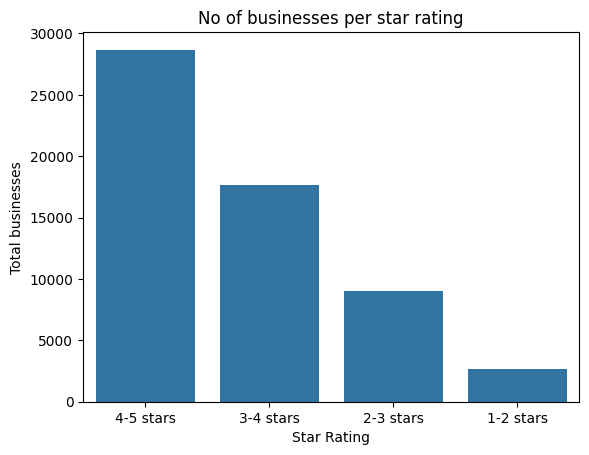

In [33]:

sns.barplot(data=df1, x=df1['star_rating'], y=df1['total_businesses'])
plt.xlabel("Star Rating")
plt.ylabel("Total businesses")
plt.title("No of businesses per star rating")
plt.show()

#### Most businesses are rated 4-5 or 3-4 stars

#### 3.Number of reviews per star rating

In [34]:
unique_businesses = """
SELECT * FROM df
GROUP BY business_id
"""
df_unique_businesses = run_query(unique_businesses)

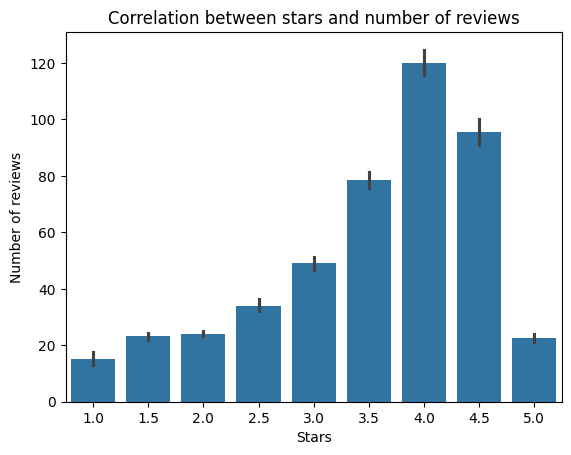

In [35]:
sns.barplot(data=df_unique_businesses, x=df_unique_businesses['stars'], y=df_unique_businesses['review_count'])
plt.xlabel("Stars")
plt.ylabel("Number of reviews")
plt.title("Correlation between stars and number of reviews")
plt.show()

#### It seems that for businesses up to 4 stars the more stars a business has, the more reviews it has. We will check if there is a correlation between the two variables using the Spearman Rank Correlation.

In [36]:
from scipy.stats import spearmanr

correlation,p_value = spearmanr(df_unique_businesses['stars'],df_unique_businesses['review_count'])
print(f"Spearman Rank Correlation: {correlation}")

print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("Correlation is statistically significant")
else:
    print("Correlation is not statistically significant")

Spearman Rank Correlation: 0.09261447073354838
P-Value: 1.357600026229779e-110
Correlation is statistically significant


#### Conclusions
1. The p-value is less than 0.05 which means that correlation is statistically significant
2. The Spearman Rank Correlation is very close to 0 but larger that 0, which indicates a positive monotonic but vey weak ralationship between the stars and number of reviews a business has. 

#### 5. Centroid locations for businesses per category

In [37]:
import folium
from folium.plugins import MarkerCluster


# Group by category and calculate median as the centroid
centroids = df.groupby('categories').agg({'latitude':'median','longitude':'median'}).reset_index()
map_center = [df['latitude'].median(), df['longitude'].median()]

category_map = folium.Map(location=map_center, zoom_start=10)

# Create a MarkerCluster to group markers
marker_cluster = MarkerCluster().add_to(category_map)

In [38]:
# Add markers to the map for each category centroid with coordinates in popup
for index,row in centroids.iterrows():
    popup_text = (f"Category: {row['categories']} <br> Latitude: {row['latitude']} <br> Longitude: {row['longitude']}")
    folium.Marker(location=[row['latitude'], row['longitude']],
                 popup=folium.Popup(popup_text, parse_html=False), icon=folium.Icon(color="blue")).add_to(marker_cluster)

In [39]:
category_map

####  4. Top cities that businesses are located per category

In [40]:
states = """
SELECT categories,state, city, COUNT(DISTINCT(business_id)) AS total_businesses
FROM df_unique_businesses
GROUP BY categories
ORDER BY total_businesses DESC
"""
run_query(states)

,categories,state,city,total_businesses
0,Restaurants,FL,New Port Richey,19747
1,Food,NJ,Clementon,10512
2,Local Services,FL,Saint Petersburg,9503
3,Bars,FL,Tampa,3906
4,Professional Services,NV,Reno,2449
5,Pizza,PA,Glen Mills,1958
6,Sandwiches,NV,Reno,1801
7,Fast Food,TN,Smyrna,1662
8,Coffee & Tea,AZ,Tucson,1539
9,Breakfast & Brunch,PA,Philadelphia,1315


### Conclusions:

#### Let's take a closer look at the Township and State that the centroid of each category is located:
| Category | Township | State |
|----------|----------|----------|
| Fast Food | Orangeville | Indiana |
| Burgers | Bobo | Indiana |
| Proffessional Services | Jefferson | Indiana |
| Local Services|  Monroe | Indiana |
| Desserts| Washington | Indiana |
| Breakfast & Brunch| Washington | Indiana|
| Bars| Washington | Indiana |
| Bakeries| Clark| Indiana|
| Food| Franklin| Indiana|
| Restaurants| Needham | Indiana|
| Specialty Food| Needham| Indiana|
| Coffe & Tea| Saltcreek| Ohaio|
| Sandwiches| Saltcreek| Ohaio|
| Pizza| Greenfield| Ohaio|


In [41]:
hour_valid = """
SELECT *
FROM df
WHERE
Open24Hours = 0 AND 
business_id NOT IN (
    SELECT business_id
    FROM df
    WHERE Monday IS NULL AND
    Tuesday IS NULL AND
    Wednesday IS NULL AND
    Thursday IS NULL AND
    Friday IS NULL AND
    Saturday IS NULL AND
    Sunday IS NULL
)
"""
df_hours_valid = run_query(hour_valid)

In [42]:
closed= """
SELECT categories,
((CAST(COUNT(CASE WHEN Monday="closed" THEN 1 END) AS REAL))/(CAST(COUNT(categories) AS REAL))) *100 AS closed_Monday,
((CAST(COUNT(CASE WHEN Tuesday="closed" THEN 1 END) AS REAL))/(CAST(COUNT(categories) AS REAL))) *100 AS closed_Tuesday,
((CAST(COUNT(CASE WHEN Wednesday="closed" THEN 1 END) AS REAL))/(CAST(COUNT(categories) AS REAL))) *100 AS closed_Wednesday,
((CAST(COUNT(CASE WHEN Thursday="closed" THEN 1 END) AS REAL))/(CAST(COUNT(categories) AS REAL))) *100 AS closed_Thursday,
((CAST(COUNT(CASE WHEN Friday="closed" THEN 1 END) AS REAL))/(CAST(COUNT(categories) AS REAL))) *100 AS closed_Friday,
((CAST(COUNT(CASE WHEN Saturday="closed" THEN 1 END) AS REAL))/(CAST(COUNT(categories) AS REAL))) *100 AS closed_Saturday,
((CAST(COUNT(CASE WHEN Sunday="closed" THEN 1 END) AS REAL))/(CAST(COUNT(categories) AS REAL))) *100 AS closed_Sunday
FROM df_hours_valid
WHERE Open24Hours = 0 AND
business_id NOT IN (
    SELECT business_id
    FROM df_hours_valid
    WHERE Monday IS NULL AND
    Tuesday IS NULL AND
    Wednesday IS NULL AND
    Thursday IS NULL AND
    Friday IS NULL AND
    Saturday IS NULL AND
    Sunday IS NULL
) GROUP BY categories
"""

run_query(closed)


,categories,closed_Monday,closed_Tuesday,closed_Wednesday,closed_Thursday,closed_Friday,closed_Saturday,closed_Sunday
0,Bakeries,17.938353,10.207175,4.244568,2.425467,1.212734,3.537140,26.174836
1,Bars,15.035318,11.056653,4.252559,1.484792,0.345971,0.807265,10.710682
2,Breakfast & Brunch,9.043928,7.352596,2.654451,1.057082,0.516796,3.664553,10.241954
3,Burgers,4.539907,3.099829,1.171589,0.585794,0.122041,1.342446,6.028802
4,Coffee & Tea,5.373636,4.324097,1.721243,0.965575,0.419815,3.043661,9.487825
5,Desserts,17.059980,11.258604,4.228122,2.015733,1.376598,2.999017,21.779744
6,Fast Food,0.896947,0.744275,0.515267,0.305344,0.133588,0.954198,5.992366
7,Food,10.506710,7.471925,3.659271,1.917283,1.177760,3.374418,15.091756
8,Local Services,3.830998,1.609019,1.171191,0.788091,0.919440,21.924256,59.654116
9,Pizza,9.174312,4.162005,1.141195,0.402775,0.268516,1.230700,8.503021


#### It seems that for each category the percentage of businesses that are not open is likely to be higher at the start(Monday) and at the end of the week(Sunday). However, the percentages are relatively low for the categories that  are closer to our coffee company.

In [43]:
# Function to split the operating hours of each day to opening and closing hour
def split_hours(row):
    if  row != 'closed':
        opening,closing = row.split("-")
        return pd.Series({'OpeningHour': opening, 'ClosingHour': closing})
    else:
        return pd.Series({'OpeningHour': None, 'ClosingHour': None})
    
days_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

for day in days_of_week:
    df_hours_valid[['OpeningHour_'+ day, 'ClosingHour_'+day]] = df_hours_valid[day].apply(split_hours)

df_hours_valid.drop(columns=days_of_week, inplace=True)
                    
df_hours_valid.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,categories,AgesAllowed,...,OpeningHour_Wednesday,ClosingHour_Wednesday,OpeningHour_Thursday,ClosingHour_Thursday,OpeningHour_Friday,ClosingHour_Friday,OpeningHour_Saturday,ClosingHour_Saturday,OpeningHour_Sunday,ClosingHour_Sunday
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,Local Services,0,...,8:0,18:30,8:0,18:30,8:0,18:30,8:0,14:0,None,None
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Restaurants,0,...,7:0,20:0,7:0,20:0,7:0,21:0,7:0,21:0,7:0,21:0
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Food,0,...,7:0,20:0,7:0,20:0,7:0,21:0,7:0,21:0,7:0,21:0
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,0,...,7:0,20:0,7:0,20:0,7:0,21:0,7:0,21:0,7:0,21:0
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Bakeries,0,...,7:0,20:0,7:0,20:0,7:0,21:0,7:0,21:0,7:0,21:0


In [44]:
hours_col = []
for day in days_of_week:
    hours_col.append('OpeningHour_'+day)
    hours_col.append('ClosingHour_'+day)

# Convert the Opening and Closing hour of each day to datetime in the desired format
for col in hours_col:
    df_hours_valid[col] = pd.to_datetime(df_hours_valid[col], format='%H:%M' ,errors='coerce')
    

In [45]:
# Calculate average opening and closing hours for weekdays and weekend
df_hours_valid['OpeningHour_Weekday'] = df_hours_valid[['OpeningHour_Monday','OpeningHour_Tuesday', 'OpeningHour_Wednesday',
                                                       'OpeningHour_Thursday', 'OpeningHour_Friday']].mean(axis=1, skipna=True)

df_hours_valid['ClosingHour_Weekday'] = df_hours_valid[['ClosingHour_Monday', 'ClosingHour_Tuesday', 'ClosingHour_Wednesday',
                                                      'ClosingHour_Thursday', 'ClosingHour_Friday']].mean(axis=1,skipna=True)

df_hours_valid['OpeningHour_Weekend'] = df_hours_valid[['OpeningHour_Saturday', 'OpeningHour_Sunday']].mean(axis=1,skipna=True)

df_hours_valid['ClosingHour_Weekend'] = df_hours_valid[['ClosingHour_Saturday', 'ClosingHour_Sunday']].mean(axis=1,skipna=True)

df_hours_valid = df_hours_valid[['categories','OpeningHour_Weekday', 'ClosingHour_Weekday', 'OpeningHour_Weekend',
                                'ClosingHour_Weekend']]

In [46]:
# Group by the 'categories' column and calculate aggregated statistics, excluding null values
aggregated_statistics = df_hours_valid.groupby('categories').agg({
    'OpeningHour_Weekday': ['min', 'max', 'mean'],
    'ClosingHour_Weekday': ['min', 'max', 'mean'],
    'OpeningHour_Weekend': ['min', 'max', 'mean'],
    'ClosingHour_Weekend': ['min', 'max', 'mean']
}, skipna=True).reset_index()

# Flatten the MultiIndex columns
aggregated_statistics.columns = [f"{col[0]}_{col[1]}" for col in aggregated_statistics.columns]

# Extract only the time part
time_columns = [col for col in aggregated_statistics.columns if 'mean' in col or 'min' in col or 'max' in col]
aggregated_statistics[time_columns] = aggregated_statistics[time_columns].applymap(lambda x: x.strftime("%H:%M") if pd.notna(x) else None)

In [47]:
aggregated_statistics

,categories_,OpeningHour_Weekday_min,OpeningHour_Weekday_max,OpeningHour_Weekday_mean,ClosingHour_Weekday_min,ClosingHour_Weekday_max,ClosingHour_Weekday_mean,OpeningHour_Weekend_min,OpeningHour_Weekend_max,OpeningHour_Weekend_mean,ClosingHour_Weekend_min,ClosingHour_Weekend_max,ClosingHour_Weekend_mean
0,Bakeries,00:00,19:00,07:32,00:00,23:00,16:42,00:00,19:00,08:08,00:00,23:00,16:49
1,Bars,00:00,23:30,11:43,00:00,23:45,12:27,00:00,23:30,11:55,00:00,23:59,12:42
2,Breakfast & Brunch,00:00,19:00,07:20,00:00,23:30,14:11,00:00,19:00,07:43,00:00,23:30,14:40
3,Burgers,00:00,20:00,07:47,00:00,23:45,12:20,00:00,19:00,08:13,00:00,23:59,12:35
4,Coffee & Tea,00:00,19:00,05:34,00:00,23:30,13:29,00:00,19:00,06:03,00:00,23:30,13:53
5,Desserts,00:00,18:00,09:51,00:00,23:30,17:38,00:00,22:00,10:34,00:00,23:30,18:19
6,Fast Food,00:00,22:00,07:42,00:00,23:30,13:36,00:00,22:00,08:14,00:00,23:59,14:03
7,Food,00:00,23:30,08:04,00:00,23:45,15:57,00:00,23:30,08:36,00:00,23:59,16:26
8,Local Services,00:00,22:00,07:30,00:00,23:59,15:43,00:00,22:00,08:13,00:00,23:59,15:02
9,Pizza,00:00,20:30,10:38,00:00,23:45,16:31,00:00,21:00,11:10,00:00,23:59,16:41


In [48]:
aggregated_statistics = aggregated_statistics[['categories_','OpeningHour_Weekday_mean', 'OpeningHour_Weekend_mean',
                                             'ClosingHour_Weekday_mean', 'ClosingHour_Weekend_mean']]
aggregated_statistics

,categories_,OpeningHour_Weekday_mean,OpeningHour_Weekend_mean,ClosingHour_Weekday_mean,ClosingHour_Weekend_mean
0,Bakeries,07:32,08:08,16:42,16:49
1,Bars,11:43,11:55,12:27,12:42
2,Breakfast & Brunch,07:20,07:43,14:11,14:40
3,Burgers,07:47,08:13,12:20,12:35
4,Coffee & Tea,05:34,06:03,13:29,13:53
5,Desserts,09:51,10:34,17:38,18:19
6,Fast Food,07:42,08:14,13:36,14:03
7,Food,08:04,08:36,15:57,16:26
8,Local Services,07:30,08:13,15:43,15:02
9,Pizza,10:38,11:10,16:31,16:41


In [49]:
# Filter the DataFrame for only four categories that are closer to our coffee company
selected_categories = ['Coffee & Tea', 'Breakfast & Brunch', 'Sandwiches', 'Fast Food']
filtered_data = aggregated_statistics[aggregated_statistics['categories_'].isin(selected_categories)]

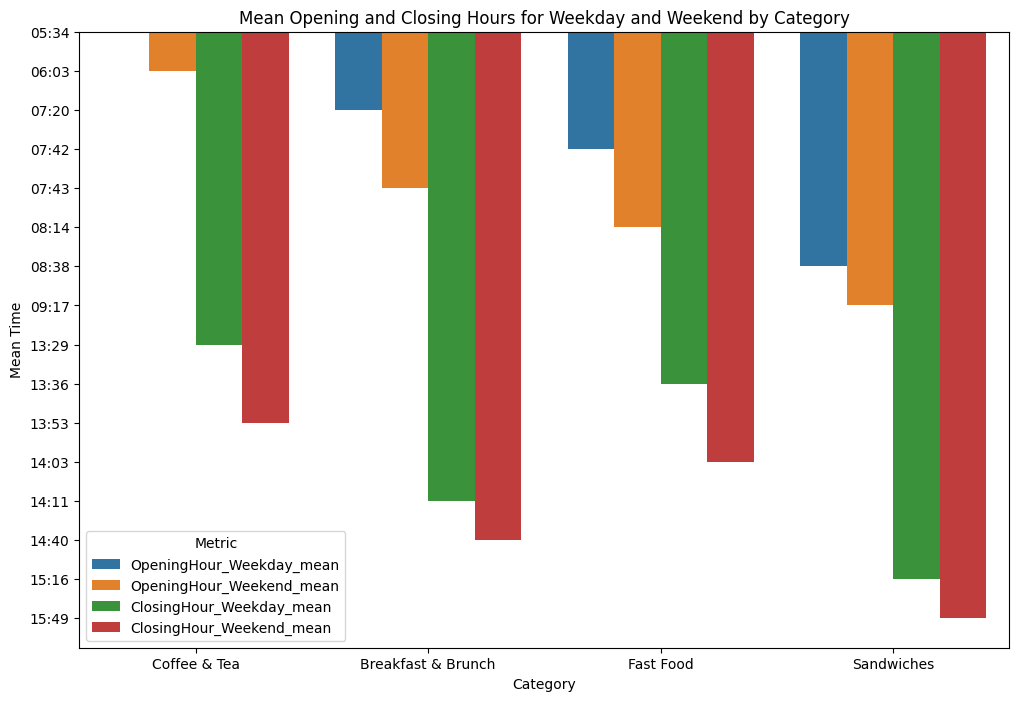

In [50]:
import matplotlib as mpl

melted_data = pd.melt(filtered_data, id_vars='categories_', var_name='Metric', value_name='Time')

# Plotting using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='categories_', y='Time', hue='Metric', data=melted_data.sort_values(by='Time'), errorbar=None)
plt.title('Mean Opening and Closing Hours for Weekday and Weekend by Category')
plt.ylabel('Mean Time')
plt.xlabel('Category')

plt.show()

#### We can see that businesses start operating later at the weekend so they close later. In any case, businesses on average operate from around 6 a.m.  up to 4 p.m.

In [51]:
filtered_df = df.loc[:,~df.columns.isin(['name', 'city', 'state', 'latitude', 'longitude',
       'stars', 'review_count', 'categories', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday'])]

query_df_b = """
SELECT * FROM filtered_df GROUP BY business_id
"""
filtered_df = run_query(query_df_b)

filtered_df['attributes'] = filtered_df.apply(lambda row:','.join(col for col in filtered_df.columns[1:] if row[col] == 1), 
                                              axis=1)

filtered_df = filtered_df.set_index('business_id')['attributes'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('attribute').reset_index()

#### Since we need to model the data, it is not that effective to have each attribute in a new column. Therefore, we will create a new column called Attributes, in which we will insert all the attributes related to a business each one in a separate line.

In [52]:
df_b = pd.merge(df, filtered_df, on='business_id', how='inner')
df_b = df_b[['business_id','name','city','state','latitude','longitude','stars','review_count','categories','attribute']]
df_b.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,categories,attribute
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton,MO,38.551126,-90.335695,3.0,15,Local Services,BusinessAcceptsCreditCards
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Restaurants,BusinessParking
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Restaurants,RestaurantsTakeOut
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Restaurants,BikeParking
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Restaurants,BusinessAcceptsCreditCards


In [53]:
# Again we keep only businesses from 4 categories that are closer to our coffee company
selected_categories = ['Coffee & Tea', 'Breakfast & Brunch', 'Sandwiches', 'Fast Food']
df_b = df_b[df_b['categories'].isin(selected_categories)].reset_index()

In [54]:
df_b = df_b[['business_id','name','city','state','latitude','longitude','stars','review_count','categories','attribute']]
df_b.head()

,business_id,name,city,state,latitude,longitude,stars,review_count,categories,attribute
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,BusinessParking
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,RestaurantsTakeOut
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,BikeParking
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,BusinessAcceptsCreditCards
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,39.955505,-75.155564,4.0,80,Coffee & Tea,OutdoorSeating


In [55]:
df_b.shape[0]

320809

### Import json file with business reviews

#### This file is very large so we will load the file using pandas option that allows us to load large data by segmenting the file into smaller chunks.

In [56]:
size = 2000000
review_json_key = 'YelpData/yelp_academic_dataset_review.json'
reviews = get_s3_json_in_chunks(review_json_key, size)

#### Here, the chunk size of 1,000,000 means Pandas will be reading 1,000,000 lines each time

In [57]:
chunk_list = []
for chunk in reviews:
    
    #Drop columns that are not needed
    chunk = chunk.drop(['useful','funny','cool'], axis=1)
    
    #Renaming column name to avoid conflict with business overall star rating
    chunk = chunk.rename(columns={'stars':'review_stars'})
    
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(df, chunk, on='business_id', how='inner')
    
    chunk_list.append(chunk_merged)
    
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)       

In [58]:
df.shape[0]

9906291

####  We select only the businesses that belong to one of the four categories that are closer to our coffe company.

In [59]:
df = df.query('categories in ["Coffee & Tea", "Breakfast & Brunch", "Sandwiches", "Fast Food"]')
df.shape[0]

1832958

In [60]:
df_reviews = df[['business_id','review_id','user_id','review_stars','text','date']].reset_index()
df_reviews.drop(columns='index', axis=1, inplace=True)

In [61]:
# Get distinct reviews
reviews_query = """
SELECT * FROM df_reviews GROUP BY business_id,review_id
"""
df_reviews = run_query(reviews_query)
df_reviews

,business_id,review_id,user_id,review_stars,text,date
0,--epgcb7xHGuJ-4PUeSLAw,-YPSb7opc8nTWPumW5P3Qw,-VmiK2zFPDvDFYeZXLnh5A,5,This place is almost always great... It gets 5...,2013-03-24 04:56:48
1,--epgcb7xHGuJ-4PUeSLAw,2Lq7CZnyQq5uA_H_qhd-pQ,WPJA9X2FUM_KgEMUToSpYw,5,this place continues to impress me. i stop in ...,2012-01-25 00:53:54
2,--epgcb7xHGuJ-4PUeSLAw,2gxy9uEh00D_przEth7VfA,qdHRpSbLkkNmL_4xHlms7Q,5,"The staff is friendly! Food is great, coffee i...",2016-08-27 23:46:21
3,--epgcb7xHGuJ-4PUeSLAw,2zrp_GcCx6RPkRURkmvkPA,QNO_NFL1oDX1ntvaXooV6w,1,"I was a regular costumer, till today. I ordere...",2015-03-07 14:33:38
4,--epgcb7xHGuJ-4PUeSLAw,3XIEGJo2iaZzEMST74y-AA,uv9f_lt1306GNF1zvkZGTA,1,"Worst bagels I've ever had, the place is dirty...",2013-11-18 19:15:29
...,...,...,...,...,...,...
1433647,zznJox6-nmXlGYNWgTDwQQ,rbTHYvWFm8sVOtLjIPkfbQ,GmcfioWVj8mfAaORL4VqRw,1,Absolutely terrible store. Never gets the orde...,2021-01-06 13:39:37
1433648,zznJox6-nmXlGYNWgTDwQQ,t8RlwtIpzAv9ITbO0HeqOw,__XsTbXWboUb1auWZ3E6aA,1,This is the closest dunkin to my work. They al...,2015-12-22 12:46:44
1433649,zznJox6-nmXlGYNWgTDwQQ,v3cgTMkOBRT8CjUy-CLQbQ,q5qnViN45NxhGUToRsdgtA,1,Worst experience at a fast food restaurant eve...,2014-10-19 19:32:25
1433650,zznJox6-nmXlGYNWgTDwQQ,vxYxLfDH6aDxCh52HvM9XQ,SF0HOdJBUzzPlBQOr_l_8w,1,I go through drive thru and other chocolate he...,2021-10-12 12:12:42


### Import json file with user information

#### The users file is also very large. Therefore, we will import the <code> Users.json </code> file the same way we imported the reviews file. 

In [ ]:
size = 2000000
users_json_key = 'YelpData/yelp_academic_dataset_user.json'
users = get_s3_json_in_chunks(users_json_key, size)

In [63]:
chunk_list = []
for chunk in users:

    #Keep only necessary columns
    chunk = chunk[['user_id','name','review_count','average_stars']]
    
    #Renaming column name to avoid conflict with business review_count
    chunk = chunk.rename(columns={'review_count':'user_review_count'})
    
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(df_reviews, chunk, on='user_id', how='inner')
    
    chunk_list.append(chunk_merged)
    
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)      

In [64]:
df.shape[0]

1433649

In [65]:
# Keep only necessary attributes in users dataframe
df_users= df[['user_id','name','user_review_count','average_stars']]

#Keep distinct users
users_query = """
SELECT * FROM df_users GROUP BY user_id
"""
df_users = run_query(users_query)
df_users.head()

,user_id,name,user_review_count,average_stars
0,---2PmXbF47D870stH1jqA,Susan,36,4.98
1,---UgP94gokyCDuB5zUssA,Leonel,16,3.44
2,--17Db1K-KujRuN7hY9Z0Q,Chantelle,592,4.00
3,--1oZcRo9-QKOtTqREKB6g,Claire,46,3.66
4,--1orhUoGFSdHXsoxqQc8g,Keny,41,4.29


In [66]:
df_users.shape[0]

678469

In [67]:
#checking data types in users dataframe
df_users.dtypes

user_id               object
name                  object
user_review_count      int64
average_stars        float64
dtype: object

#### After cleaning the data, we export it to csv.

In [ ]:
# File paths to store csv files with cleaned data
business_path = 'YelpData/businesses.csv'
reviews_path='YelpData/reviews.csv'
users_path = 'YelpData/users.csv'

# Call function to store cleaned data to AWS S3
export_csv_to_S3(df_b, business_path)
export_csv_to_s3(df_reviews, reviews_path)
export_csv_to_s3(df_users, users_path)